In [1]:
%load_ext autoreload
%autoreload 2

In [225]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../new_modules')
import ObsModels
import utils

import ChemotaxisModels as chem

import FSC as controller

from scipy.optimize import curve_fit

In [226]:
import torch
import copy

In [526]:
results_model = chem.gradx_ecoli3D(NRep = 250, NSteps = 10000, grad = 0.5, ttumble = 0.1)
tau_sub = 100


c_data = [res["concentrations"][::tau_sub] for res in results_model]
cmean = np.concatenate(c_data).mean()
cstd = np.concatenate(c_data).std()

c_data = [x for x in c_data]

trajectories_data = []
actions = []
for i, curr_res in enumerate(results_model):

    actions.append(curr_res["actions"].astype(int)[::tau_sub])
    ccurr = c_data[i]

    dict_traj = {}
    dict_traj["actions"] = actions[-1]
    dict_traj["features"] = np.array([np.ones(ccurr.size).astype(np.float32),
                                      ccurr])

    trajectories_data.append(dict_traj)

Number of trajectories:  250
Number of tumbling at the beginning:  20
Fraction of tumbling at the beginning:  8.0 %


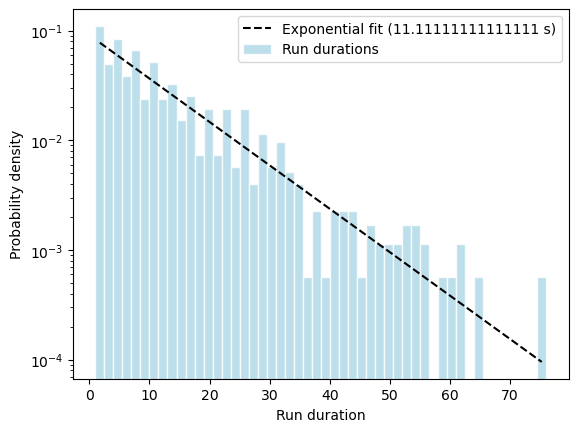

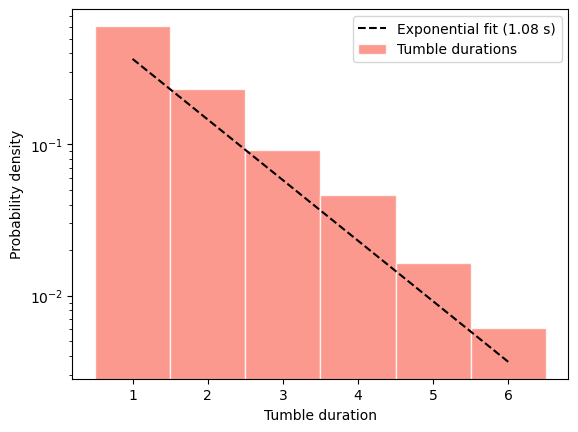

In [527]:
run_durations = np.concatenate([utils.filter_durations(utils.extract_durations(act), 0)[1:-1] for act in actions])
tumble_durations = np.concatenate([utils.filter_durations(utils.extract_durations(act), 1)[1:-1] for act in actions])

first_action = np.array([tr["actions"][0] for tr in trajectories_data])

print("Number of trajectories: ", len(trajectories_data))
print("Number of tumbling at the beginning: ", np.sum(first_action))
print("Fraction of tumbling at the beginning: ", np.round(np.sum(first_action) / len(trajectories_data) * 100, 2), "%")

run_values, run_cumulative = utils.get_cumulative(run_durations)
run_params, _ = curve_fit(utils.expcum_fit, run_values, run_cumulative, p0=[0.01])
run_exponent = run_params[0]

tumble_values, tumble_cumulative = utils.get_cumulative(tumble_durations)
tumble_params, _ = curve_fit(utils.expcum_fit, tumble_values, tumble_cumulative, p0=[0.01])
tumble_exponent = tumble_params[0]

h_run_dur, bins_run_dur = np.histogram(run_durations, bins=50, density=True)
bins_run_dur = (bins_run_dur[1:] + bins_run_dur[:-1]) / 2

h_tumble_dur, bins_tumble_dur = np.histogram(tumble_durations, bins=np.arange(1, np.max(tumble_durations) + 1), density=True)
bins_tumble_dur = bins_tumble_dur[:-1]

plt.bar(bins_run_dur, h_run_dur, width=np.diff(bins_run_dur)[0], label="Run durations", color = 'lightblue', alpha = 0.8, lw = 1, edgecolor = 'w')
plt.plot(bins_run_dur, run_exponent * np.exp(-run_exponent * bins_run_dur), label=f"Exponential fit ({1/np.round(run_exponent, 2)} s)", ls="--", color = 'black')
plt.yscale("log")
plt.xlabel("Run duration")
plt.ylabel("Probability density")
plt.legend()
plt.show()

plt.bar(bins_tumble_dur, h_tumble_dur, width=np.diff(bins_tumble_dur)[0], label="Tumble durations", color = 'salmon', alpha = 0.8, lw = 1, edgecolor = 'w')
plt.plot(bins_tumble_dur, tumble_exponent * np.exp(-tumble_exponent * bins_tumble_dur), label=f"Exponential fit ({np.round(1/tumble_exponent, 2)} s)", ls="--", color = 'black')
plt.yscale("log")
plt.xlabel("Tumble duration")
plt.ylabel("Probability density")
plt.legend()
plt.show()

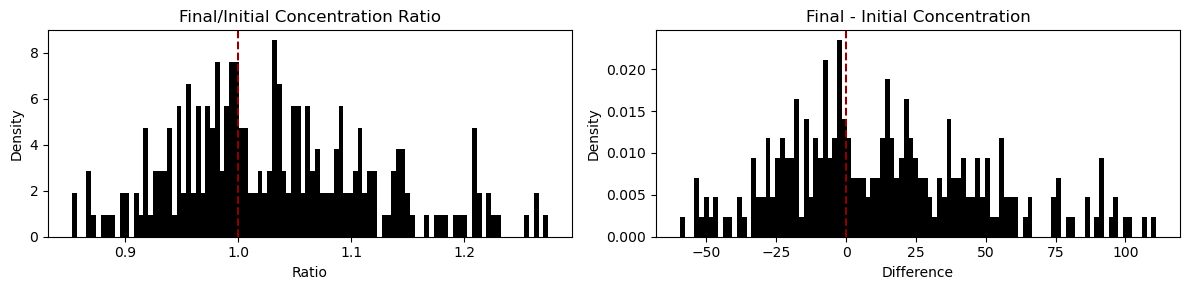

In [528]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

cratio_data = np.array([tr["features"][1][-1] / tr["features"][1][0] for tr in trajectories_data])
ax1.hist(cratio_data, bins=100, density=True, color='black')
ax1.set_title('Final/Initial Concentration Ratio')
ax1.set_xlabel('Ratio')
ax1.set_ylabel('Density')
ax1.axvline(x=1, color='darkred', ls='--')

cdiff_data = np.array([tr["features"][1][-1] - tr["features"][1][0] for tr in trajectories_data])
ax2.hist(cdiff_data, bins=100, density=True, color='black')
ax2.set_title('Final - Initial Concentration')
ax2.set_xlabel('Difference')
ax2.set_ylabel('Density')
ax2.axvline(x=0, color='darkred', ls='--')

plt.tight_layout()
plt.show()

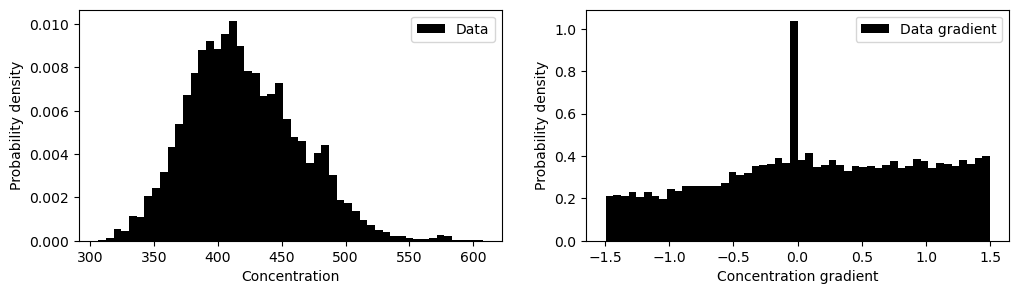

In [529]:
idx_t_run_data = []
idx_t_tumble_data = []

cgrad_data = [np.diff(cc) for cc in c_data]
#cgrad_data = [np.convolve(cc, np.ones(5) / 5, mode = "same") for cc in cgrad_data]

for tr in trajectories_data:
    idx_t_run_data.append(tr["actions"] == 0)
    idx_t_tumble_data.append(tr["actions"] == 1)

c_run_data = np.concatenate([c_data[i][idx_t_run_data[i]] for i in range(len(c_data))])
c_tumble_data = np.concatenate([c_data[i][idx_t_tumble_data[i]] for i in range(len(c_data))])

cgrad_run_data = np.concatenate([cgrad_data[i][idx_t_run_data[i][1:]] for i in range(len(cgrad_data))])
cgrad_tumble_data = np.concatenate([cgrad_data[i][idx_t_tumble_data[i][1:]] for i in range(len(cgrad_data))])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))


hc_data = ax1.hist(np.concatenate(c_data), bins=50, density=True, alpha=1, label="Data", color = 'k')
hgrad_data = ax2.hist(np.concatenate(cgrad_data), bins=50, density=True, alpha=1, label="Data gradient", color = 'k')

xlim_c_data = ax1.get_xlim()
xlim_cgrad_data = ax2.get_xlim()

for ax in [ax1, ax2]:
    #ax.set_yscale("log")
    ax.set_ylabel("Probability density")
    ax.legend()

ax1.set_xlabel("Concentration")
ax2.set_xlabel("Concentration gradient")

plt.show()

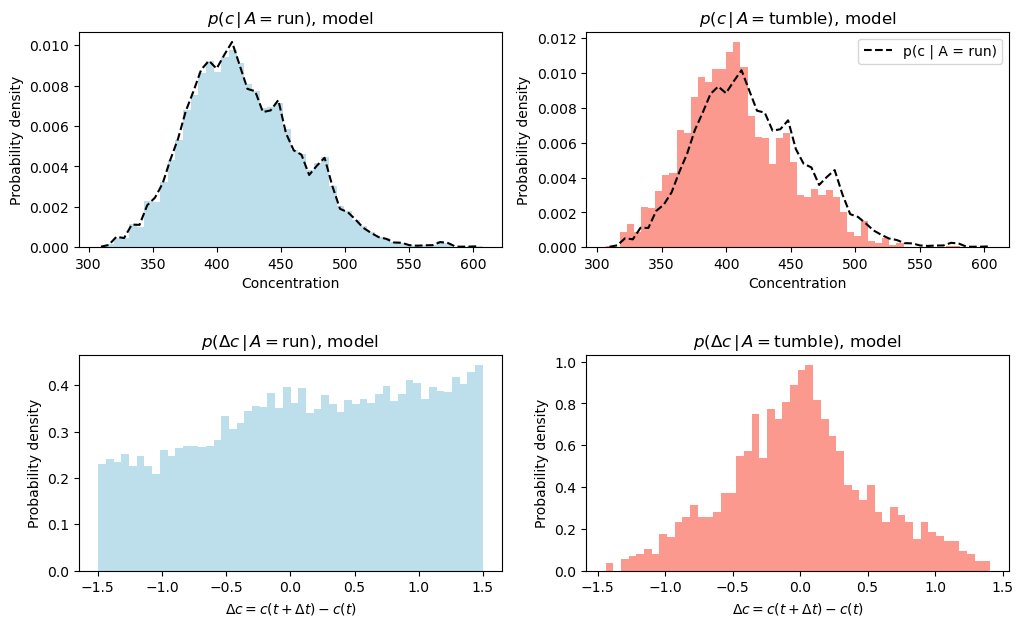

In [530]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

for ax in axes.flatten():
    ax.set_ylabel("Probability density")

axes[0, 0].hist(c_run_data, bins=50, density=True, alpha=0.8, color='lightblue')
axes[0, 0].set_title(r"$p(c \, | \, A = \mathrm{run})$, model")
axes[0, 0].set_xlabel("Concentration")
axes[0, 0].plot((hc_data[1][1:] + hc_data[1][:-1]) / 2, hc_data[0], color='k', ls='--', label="Data")

htumb_c = axes[0, 1].hist(c_tumble_data, bins=50, density=True, alpha=0.8, color='salmon')
axes[0, 1].set_title(r"$p(c \, | \, A = \mathrm{tumble})$, model")
axes[0, 1].set_xlabel("Concentration")
axes[0, 1].plot((hc_data[1][1:] + hc_data[1][:-1]) / 2, hc_data[0], color='k', ls='--', label="p(c | A = run)")
axes[0, 1].legend()


axes[1, 0].hist(cgrad_run_data, bins=50, density=True, alpha=0.8, color='lightblue')
axes[1, 0].set_title(r"$p(\Delta c \, | \, A = \mathrm{run})$, model")
axes[1, 0].set_xlabel(r"$\Delta c = c(t + \Delta t) - c(t)$")

htumb_c = axes[1, 1].hist(cgrad_tumble_data[cgrad_tumble_data != 0], bins=50, density=True, alpha=0.8, color='salmon')
axes[1, 1].set_title(r"$p(\Delta c \, | \, A = \mathrm{tumble})$, model")
axes[1, 1].set_xlabel(r"$\Delta c = c(t + \Delta t) - c(t)$")
#axes[1, 1].set_yscale('log')

plt.subplots_adjust(hspace = 0.5)
plt.show()

In [532]:
np.sum(cgrad_tumble_data < 0), np.sum(cgrad_tumble_data > 0)

(777, 726)

In [504]:
# bin the cgrad_tumble_data; inside each bin, count how many times it runs or tumbles
n_bins = 50
bins_cgrad = np.linspace(np.min(np.concatenate(cgrad_data)),
                         np.max(np.concatenate(cgrad_data)), n_bins + 1)

n_runs = []
n_tumbles = []

for idx_tr, tr in enumerate(trajectories_data):
    cgrad_tr = cgrad_data[idx_tr]
    actions_tr = tr["actions"][1:]
    curr_idx_t_run = actions_tr == 0
    curr_idx_t_tumble = actions_tr == 1

    n_run_tr = np.histogram(cgrad_tr[curr_idx_t_run], bins=bins_cgrad)[0]
    n_tumble_tr = np.histogram(cgrad_tr[curr_idx_t_tumble], bins=bins_cgrad)[0]

    n_runs.append(n_run_tr )
    n_tumbles.append(n_tumble_tr )

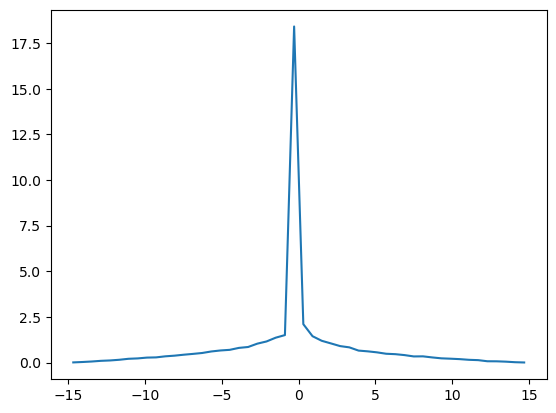

In [505]:
plt.plot((bins_cgrad[1:] + bins_cgrad[:-1])/2, np.nanmean(n_tumbles, axis = 0))

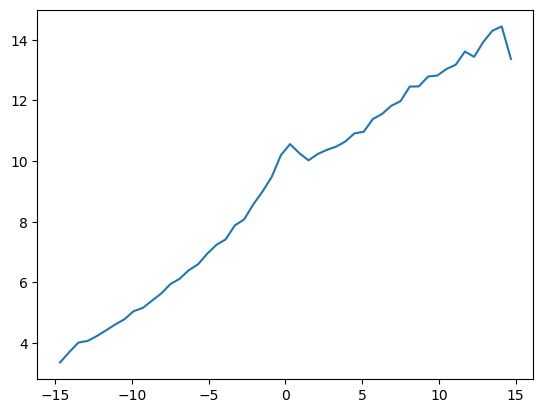

In [506]:
plt.plot((bins_cgrad[1:] + bins_cgrad[:-1])/2, np.nanmean(n_runs, axis = 0))

In [507]:
np.nanmean(n_runs, axis = 0) + np.nanmean(n_tumbles, axis = 0)

array([ 3.374,  3.736,  4.08 ,  4.17 ,  4.351,  4.576,  4.824,  5.017,
        5.328,  5.448,  5.746,  6.017,  6.38 ,  6.6  ,  6.931,  7.21 ,
        7.614,  7.94 ,  8.228,  8.738,  9.114,  9.73 , 10.362, 10.984,
       28.605, 12.667, 11.711, 11.221, 11.285, 11.277, 11.312, 11.303,
       11.533, 11.529, 11.875, 12.017, 12.236, 12.314, 12.799, 12.749,
       13.024, 13.036, 13.228, 13.329, 13.748, 13.512, 14.002, 14.354,
       14.461, 13.375])

In [508]:
np.sum(cgrad_tumble_data == 0)

16238

In [525]:
np.sum(cgrad_tumble_data < 0), np.sum(cgrad_tumble_data > 0)

(15215, 14801)

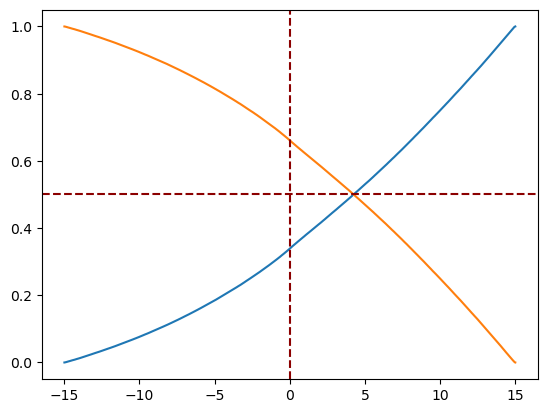

In [510]:
plt.plot(*utils.get_cumulative(cgrad_run_data))
plt.plot(*utils.get_inverse_cumulative(cgrad_run_data))
plt.axvline(x=0, color='darkred', ls='--')
plt.axhline(y=0.5, color='darkred', ls='--')

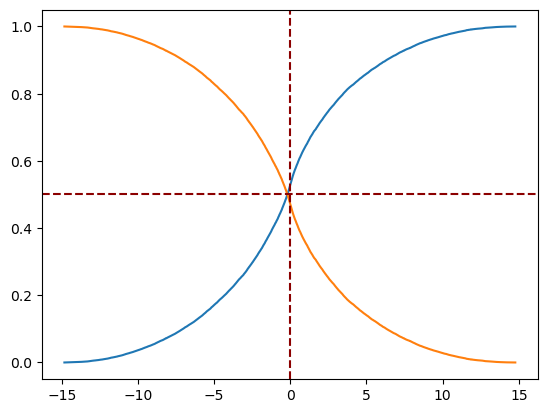

In [511]:
plt.plot(*utils.get_cumulative(cgrad_tumble_data[cgrad_tumble_data != 0]))
plt.plot(*utils.get_inverse_cumulative(cgrad_tumble_data[cgrad_tumble_data != 0]))
plt.axvline(x=0, color='darkred', ls='--')
plt.axhline(y=0.5, color='darkred', ls='--')

In [220]:
np.unique(np.concatenate([utils.filter_durations(utils.extract_durations(tr["actions"]), 1)[1:-1] for tr in trajectories]), return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1462,  596,  248,   99,   52,   15,    7,    3,    1]))

In [221]:
np.mean(np.concatenate([utils.filter_durations(utils.extract_durations(tr["actions"]), 1)[1:-1] for tr in trajectories]))

1.7019734192509062

(array([1.462e+03, 5.960e+02, 2.480e+02, 9.900e+01, 0.000e+00, 5.200e+01,
        1.500e+01, 7.000e+00, 3.000e+00, 1.000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

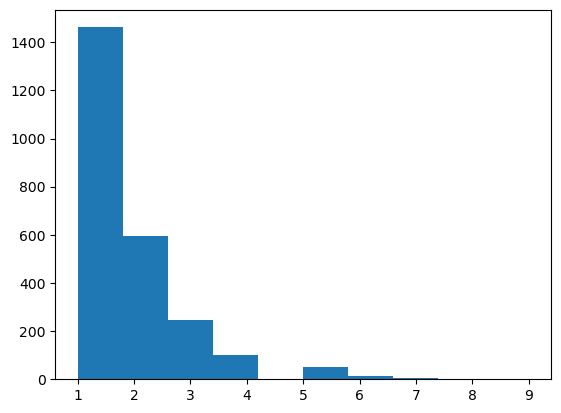

In [222]:
plt.hist(np.concatenate([utils.filter_durations(utils.extract_durations(tr["actions"]), 1)[1:-1] for tr in trajectories]))

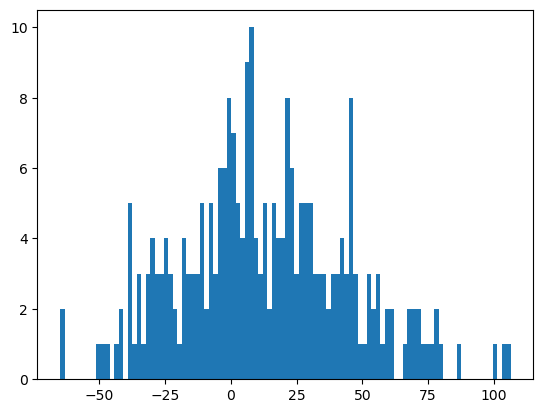

In [214]:
plt.hist([tr["features"][1][-1] - tr["features"][1][0] for tr in trajectories], bins = 100)
plt.show()

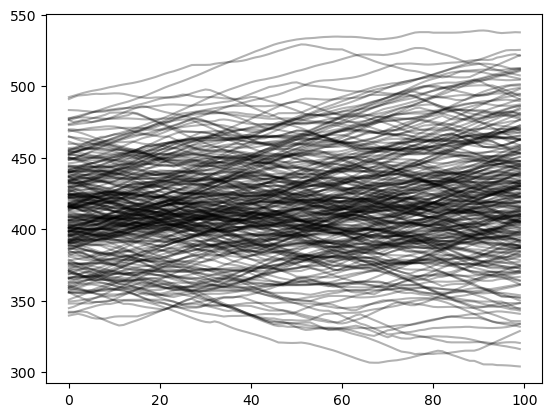

In [215]:
for tr in trajectories:
    plt.plot(tr["features"][1], c = 'k', alpha = 0.3)

In [197]:
F = 2
M = 2
A = 2

seed = 0

FSC_tofit = controller.FSC("continuous", M = M, A = A, F = F, seed = seed)

In [198]:
NEpochs = 10
NBatch = 10
lr = (0.05, 0.05)
gamma = 0.99
train_split = 0.8

In [199]:
tloss, vloss = FSC_tofit.fit(trajectories, NEpochs = NEpochs,
                             NBatch = NBatch, lr = lr, gamma = gamma, train_split = train_split)

Training with 80 trajectories and validating with 20 trajectories. Using a single learning rate of 0.05.
Epoch 1 - Training loss: 225.80028686523434, Validation loss: 135.54172477722167 - Learning rate: 0.05
Epoch 2 - Training loss: 114.75412979125976, Validation loss: 83.98303089141845 - Learning rate: 0.0495
Epoch 3 - Training loss: 91.38831024169922, Validation loss: 76.7837532043457 - Learning rate: 0.049005
Epoch 4 - Training loss: 86.87002563476562, Validation loss: 71.838547706604 - Learning rate: 0.04851495
Epoch 5 - Training loss: 78.55912246704102, Validation loss: 60.73135242462158 - Learning rate: 0.0480298005
Epoch 6 - Training loss: 63.957509613037104, Validation loss: 48.38766050338745 - Learning rate: 0.047549502495
Epoch 7 - Training loss: 53.41776657104492, Validation loss: 43.970196628570555 - Learning rate: 0.04707400747005
Epoch 8 - Training loss: 51.17436752319337, Validation loss: 43.952565383911136 - Learning rate: 0.0466032673953495
Epoch 9 - Training loss: 51.

In [200]:
FSC_tofit.set_mode("generation")

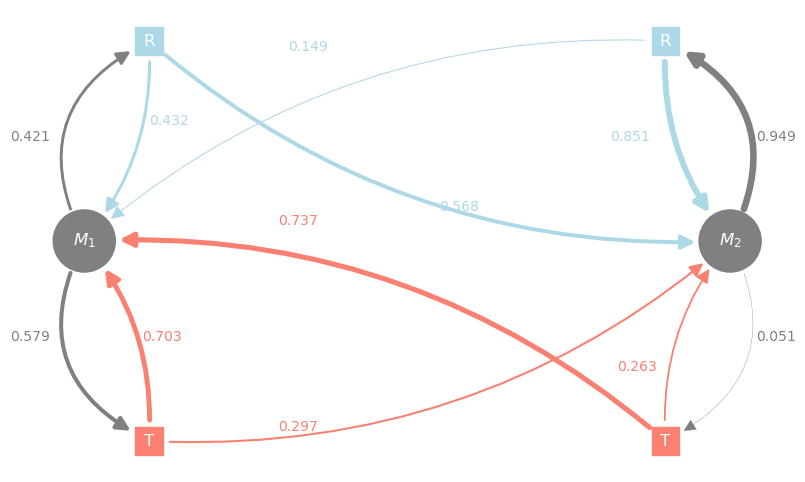

In [215]:
ftest = np.array([1, 0.001])

FSC_tofit.plot_FSC(features = ftest, figsize = (10, 6))

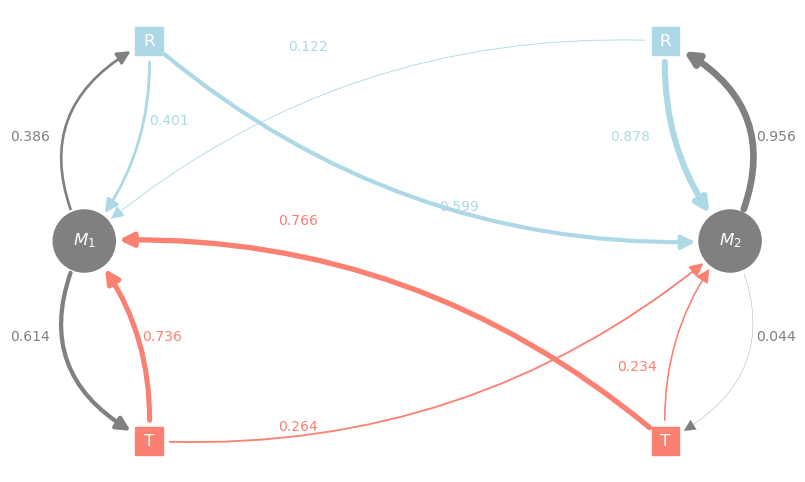

In [217]:
ftest = np.array([1, 0.1])

FSC_tofit.plot_FSC(features = ftest, figsize = (10, 6))

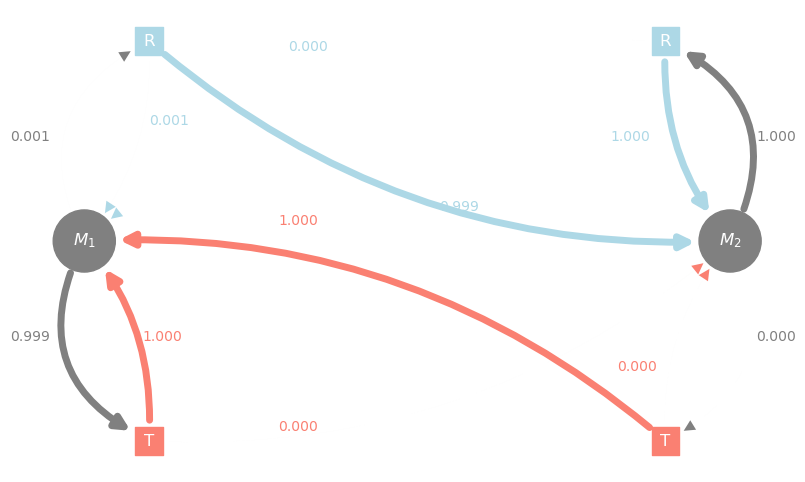

In [216]:
ftest = np.array([1, 5])

FSC_tofit.plot_FSC(features = ftest, figsize = (10, 6))

In [204]:
gt = FSC_tofit.generate_trajectories()

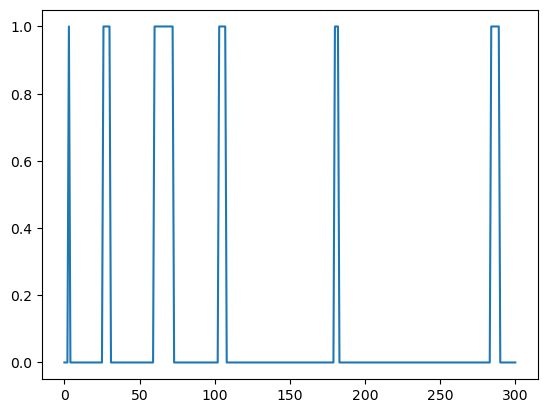

In [205]:
plt.plot(gt[0]["actions"])

In [213]:
np.unique(np.concatenate([utils.filter_durations(utils.extract_durations(tr["actions"]), 1)[1:-1] for tr in gt]), return_counts = True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 24]),
 array([113,  89,  75,  49,  40,  38,  29,  23,  14,  14,  11,   9,   4,
          3,   9,   4,   3,   2,   3,   2,   1,   2,   3]))

In [ ]:
### previous test

In [180]:
FSC_tofit.set_mode("generation")

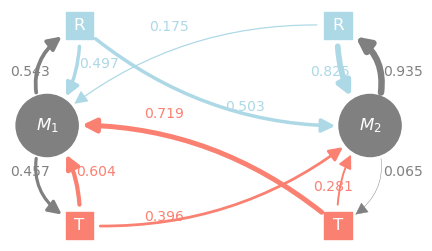

In [191]:
ftest = np.array([1, 0.001])

FSC_tofit.plot_FSC(features = ftest)

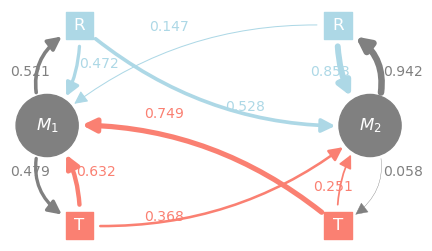

In [181]:
ftest = np.array([1, 0.1])

FSC_tofit.plot_FSC(features = ftest)

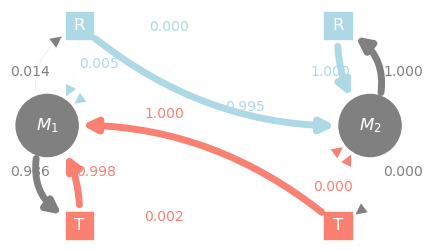

In [192]:
ftest = np.array([1, 5])

FSC_tofit.plot_FSC(features = ftest)

In [185]:
gt = FSC_tofit.generate_trajectories()

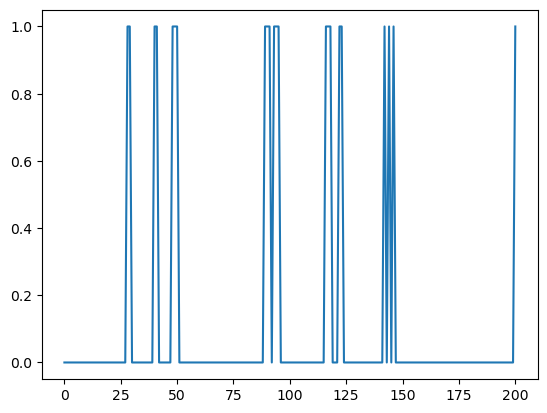

In [188]:
plt.plot(gt[0]["actions"])

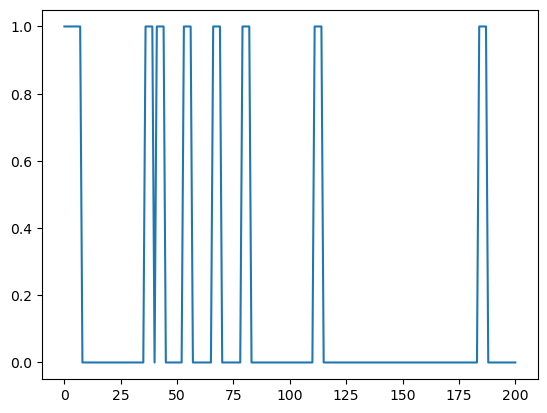

In [190]:
plt.plot(res[0]["actions"][::tau_sub])

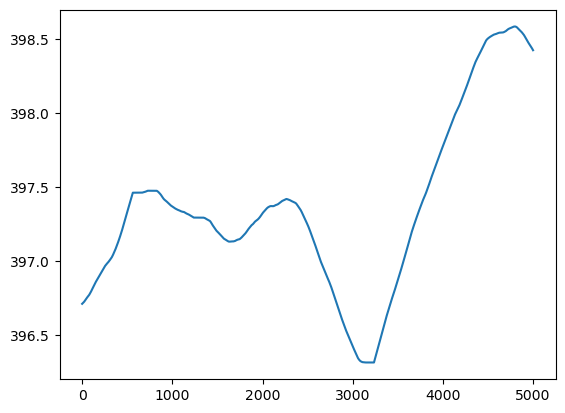

In [ ]:
trajectories = [{"features": torch.tensor(res["features"]), "targets": torch.tensor(res["targets"])}]

In [144]:
res[0]["actions"].shape

(5001,)

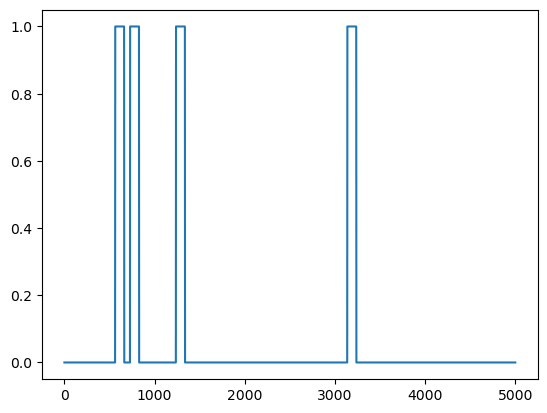

In [145]:
plt.plot(res[1]["actions"])

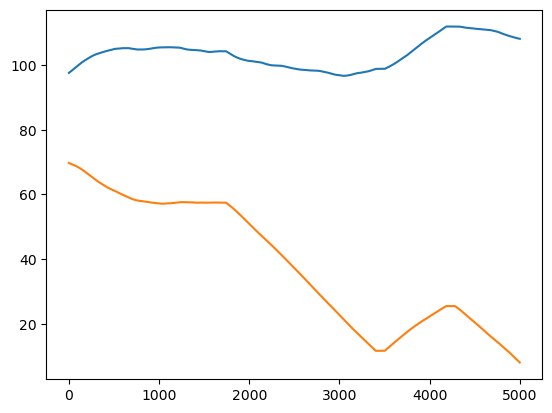

In [146]:
plt.plot(res[0]["pos_xyz"][0])
plt.plot(res[0]["pos_xyz"][1])